# Face Recognition


In [ ]:
import os
import numpy as np
import scipy as sc
import pandas as pd
from PIL import Image
from math import floor, ceil
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA as RPCA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

## 1- Understand the format and download data

In [ ]:
!unzip archive.zip

In [ ]:
def readFile(path):
  image = Image.open(path)
  imageVector = np.asarray(image)
  imageVector = imageVector.flatten()
  return imageVector

## 2- Generate Data Matrix and Label Vector


In [ ]:
def loadImages():
  images = []
  labels = []
  for id in range(1,41):
    for img in range(1,11):
      path = f's{id}/{img}.pgm'
      img = readFile(path)
      images.append(img)
      labels.append(id) 
  npimages = np.array(images, dtype=np.uint8)
  nplabels = np.array(labels, dtype=np.uint8)

  return npimages, nplabels

## 3- Split dataset evenly


In [ ]:
def splitdataEvenly(dataMatrix, labelVector): 
  print(dataMatrix.dtype, labelVector.dtype)
  trainingMatrix = np.zeros((int(dataMatrix.shape[0]/2), dataMatrix.shape[1]), dtype=np.uint8)
  trainingVector = np.zeros(int(labelVector.shape[0]/2), dtype=np.uint8)
  testingMatrix = np.zeros((int(dataMatrix.shape[0]/2), dataMatrix.shape[1]), dtype=np.uint8)
  testingVector = np.zeros(int(labelVector.shape[0]/2), dtype=np.uint8)
  for i in range(dataMatrix.shape[0]):
    if (i % 2 == 0):
      trainingMatrix[int(i/2)] = dataMatrix[i]
      trainingVector[int(i/2)] = labelVector[i]
    else:
      testingMatrix[floor(i/2)] = dataMatrix[i]
      testingVector[floor(i/2)] = labelVector[i]
  
  return trainingMatrix, trainingVector, testingMatrix, testingVector
    


In [ ]:
images, labels = loadImages()

In [ ]:
trainingMatrix, trainingVector, testingMatrix, testingVector = splitdataEvenly(images, labels)

## 4- PCA Classification


In [ ]:
def PCA(data, alpha):
  meanVector = np.mean(data, axis = 0)
  z = data - meanVector
  cov = np.cov(z.transpose(), bias = True)

  eigenValues, eigenVectors = sc.linalg.eigh(cov)
  eigenValues = np.real(eigenValues)
  eigenVectors = np.real(eigenVectors)
  eigenValues = np.abs(eigenValues)
  sort_perm = eigenValues.argsort()
  eigenValues = np.flip(eigenValues[sort_perm])
  eigenVectors = np.flip(eigenVectors[:, sort_perm], axis = 1)

  localAlpha = 0;
  i = 0
  eigenValuesSum = np.sum(eigenValues)

  while (localAlpha < alpha):
    localAlpha += eigenValues[i] / eigenValuesSum
    i += 1

    
  projectionMatrix = eigenVectors[:, :i]
  projectedData = np.matmul(z, projectionMatrix)
  return projectedData, projectionMatrix
      

In [ ]:
alpha = [0.8,0.85,0.9,0.95]

for a in alpha:
  projectedData, projectionMatrix = PCA(trainingMatrix, a)

  projectedTestData = np.matmul((testingMatrix - np.mean(testingMatrix, axis = 0)), projectionMatrix)

  knc = KNeighborsClassifier(n_neighbors=1)
  knc.fit(projectedData, trainingVector)

  predictedLabels = knc.predict(projectedTestData)

  accuracy = accuracy_score(testingVector, predictedLabels)
  print(f'for {a}: accuracy = {accuracy}')





for 0.8: accuracy = 0.95
for 0.85: accuracy = 0.95
for 0.9: accuracy = 0.935
for 0.95: accuracy = 0.94


- As seen above increasing alpha doesn't necessarily mean that the accuracy will increase.

- Increasing alpha too much adds extra dimensions that may be noisy and don't contribute to the variance of the data too much which would make a simple classifer as knn classify wrong data.




## 5- LDA Classification

In [ ]:
def classMeans(data, labels, labelsCount):
  means = dict()
  for i in range(1, labelsCount + 1):
    vectorsPos = np.where(labels == i)
    vectors = np.take(data, vectorsPos, axis = 0)
    means[i] = np.mean(vectors, axis = 1)
  return means

In [ ]:
def overallMean(data):
  return np.mean(data, axis = 0)

In [ ]:
def calculateScatterMatrices(data, labels, labelsCount):
  means = classMeans(data, labels, labelsCount)
  overallmean = overallMean(data)
  S = np.zeros((len(data[0]),len(data[0])))
  Sb = np.zeros((len(data[0]), len(data[0])))
  for i in range(1, labelsCount):
    vectorsPos = np.where(labels == i)
    Z = np.take(data, vectorsPos, axis = 0)[0] - means[i][0]
    S += np.dot(Z.T, Z)
    
    nk = len(np.where(labels == i)[0])
    currentMean = means[i][0].reshape(len(data[0]),1) # make column vector
    overallm = overallmean.reshape(len(data[0]),1) # make column vector
    Sb += nk * (currentMean - overallm).dot((currentMean - overallm).T)
  return S, Sb 

In [ ]:
def LDA(n, data, labels):
  S, Sb = calculateScatterMatrices(data, labels, len(np.unique(labels)))
  S_inv = sc.linalg.pinv(S)
  W = np.dot(S_inv, Sb)
  print("The within-class matrix Sw = \n",S,"\n")
  print("The inverse within-class matrix Sw = \n",S_inv,"\n")
  print("The between-class matrix Sb = \n",Sb,"\n")
  eigenValues, eigenVectors = sc.linalg.eig(W)
  print("Eigenvectors before any operation = \n",eigenValues, eigenVectors,"\n")
  eigenValues = np.real(eigenValues)
  eigenVectors = np.real(eigenVectors)
  eigenValues = np.abs(eigenValues)
  sort_perm = eigenValues.argsort()
  eigenValues = np.flip(eigenValues[sort_perm])
  eigenVectors = np.flip(eigenVectors[:, sort_perm], axis = 1)

  projectionMatrix = eigenVectors[:, :n]

  print("Projection Matrix = \n", projectionMatrix, "\n")

  return projectionMatrix

In [ ]:
projectionMatrix = LDA(39, trainingMatrix, trainingVector)

projectedTrain = np.matmul(trainingMatrix - np.mean(trainingMatrix, axis = 0), projectionMatrix)
projectedTest = np.matmul(testingMatrix- np.mean(testingMatrix, axis = 0), projectionMatrix)

knc = KNeighborsClassifier(n_neighbors=1)
knc.fit(projectedTrain, trainingVector)

predictedLabels = knc.predict(projectedTest)

accuracy = accuracy_score(testingVector, predictedLabels)
print(f'LDA accuracy = {accuracy}')


The within-class matrix Sw = 
 [[26656.  26812.8 25523.  ...  2432.4  1023.8  1637.8]
 [26812.8 29431.6 27181.4 ...  1939.8   358.4   644.2]
 [25523.  27181.4 28030.8 ...  2999.6   720.2  -413.4]
 ...
 [ 2432.4  1939.8  2999.6 ... 77763.6 64940.8 42543. ]
 [ 1023.8   358.4   720.2 ... 64940.8 72884.4 53673.8]
 [ 1637.8   644.2  -413.4 ... 42543.  53673.8 75447.6]] 

The inverse within-class matrix Sw = 
 [[ 6.75758612e-10  4.47799592e-10  3.55528605e-10 ... -7.56014067e-11
  -3.63567149e-10 -3.46229221e-10]
 [ 4.47799592e-10  5.97548683e-10  4.21934634e-10 ... -2.28564660e-11
  -2.13757766e-10 -2.06358312e-10]
 [ 3.55528605e-10  4.21934634e-10  6.16647802e-10 ...  3.00840469e-10
   7.76705616e-11 -8.18384695e-11]
 ...
 [-7.56014067e-11 -2.28564660e-11  3.00840469e-10 ...  7.20457132e-09
   4.69731676e-09  2.21335417e-09]
 [-3.63567149e-10 -2.13757766e-10  7.76705616e-11 ...  4.69731676e-09
   6.43455167e-09  3.93704994e-09]
 [-3.46229221e-10 -2.06358312e-10 -8.18384695e-11 ...  2.21335

## 6- Classifier Tuning


In [ ]:
projectedTrain = np.matmul(trainingMatrix, projectionMatrix)
projectedTest = np.matmul(testingMatrix, projectionMatrix)
K = [1, 3, 5, 7]
LDA_accuracy = []
for k in K:
  knc = KNeighborsClassifier(n_neighbors=k)
  knc.fit(projectedTrain, trainingVector)

  predictedLabels = knc.predict(projectedTest)

  accuracy = accuracy_score(testingVector, predictedLabels)
  LDA_accuracy.append(accuracy)
  print(f'for {k} neighbors: accuracy = {accuracy}')

for 1 neighbors: accuracy = 0.945
for 3 neighbors: accuracy = 0.955
for 5 neighbors: accuracy = 0.945
for 7 neighbors: accuracy = 0.945


In [ ]:
projectedData, projectionMatrix = PCA(trainingMatrix, 0.85) # Assuming a fixed alpha
projectedTestData = np.matmul((testingMatrix - np.mean(testingMatrix, axis = 0)), projectionMatrix)

PCA_accuracy = []
for k in K:
  knc = KNeighborsClassifier(n_neighbors=k)
  knc.fit(projectedData, trainingVector)

  predictedLabels = knc.predict(projectedTestData)

  accuracy = accuracy_score(testingVector, predictedLabels)
  PCA_accuracy.append(accuracy)
  print(f'for {k} neighbors: accuracy = {accuracy}')

for 1 neighbors: accuracy = 0.95
for 3 neighbors: accuracy = 0.895
for 5 neighbors: accuracy = 0.845
for 7 neighbors: accuracy = 0.78


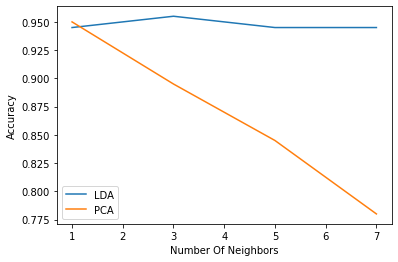

In [ ]:
plt.plot(K, LDA_accuracy, label = "LDA")
plt.plot(K, PCA_accuracy, label = "PCA")
plt.xlabel('Number Of Neighbors')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## 7-Non-Face vs Face Classification


In [ ]:
def loadNonFace():
  images = []
  for id in range(1,682):
    path = f'drive/MyDrive/Pattern Lab 1 Data/Non Face Images/nonface/d ({id}).jpg'
    image = Image.open(path)
    image = image.resize((92, 112)).convert('L')
    imageVector = np.asarray(image)
    imageVector = imageVector.flatten()
    images.append(imageVector)
  npimages = np.array(images, dtype=np.uint8)

  return npimages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def get_faces_nonfaces_data(faces, nonfaces, k):
  # k: number of nonfaces in training
  # labels: face => 1, nonface => 0
  nonfacesTesting = nonfaces[:200]
  nonfacesTraining = nonfaces[200:200+k]
  facesTraining,_, facesTesting, _ = splitdataEvenly(faces, np.array([1]*400))
  
  hybridTraining = np.concatenate((nonfacesTraining, facesTraining), axis=0)
  hybridTrainingLabels = np.asarray([0]*len(nonfacesTraining) + [1]*len(facesTraining))

  hybridTesting = np.concatenate((nonfacesTesting, facesTesting), axis = 0) 
  hybridTestingLabels = np.asarray([0]*len(nonfacesTesting) + [1]*len(facesTesting))

  return hybridTraining, hybridTrainingLabels, hybridTesting, hybridTestingLabels

In [ ]:
def number_success_fail(predicted_labels, actual_labels):
  success = [0,0]
  fail = [0,0]
  for i in range(len(predicted_labels)):
    if predicted_labels[i] == actual_labels[i]:
      success[actual_labels[i]] += 1
    else:
      fail[actual_labels[i]] += 1
  return success, fail

In [ ]:
nonfaces = loadNonFace()
faces = images
training, _, testing, testingLabels = get_faces_nonfaces_data(faces, nonfaces, 100)

for a in [0.8, 0.9]:
  accuracies = []
  n_nonfaces_images = [100,200,300]
  for k in n_nonfaces_images:
    training, trainingLabels, testing, testingLabels = get_faces_nonfaces_data(faces, nonfaces, k)

    projectedData, projectionMatrix = PCA(training, a)
    projectedTestData = np.matmul((testing - np.mean(testing, axis=0)), projectionMatrix)

    knc = KNeighborsClassifier(n_neighbors=1)
    knc.fit(projectedData, trainingLabels)

    predictedLabels = knc.predict(projectedTestData)
    n_success, n_fail = number_success_fail(predictedLabels, testingLabels)
    accuracy = accuracy_score(testingLabels, predictedLabels)
    accuracies.append(accuracy)
    print(f'for {a}, {k}:')
    print(f'\tfaces #success: {n_success[1]}, #fail: {n_fail[1]} ')
    print(f'\tnonfaces #success: {n_success[0]}, #fail: {n_fail[0]} ')
    print(f'\tAccuarcy: {accuracy*100}%')
    
  plt.plot([100,200,300], accuracies)
  plt.xlabel('Number Of Nonfaces Images')
  plt.ylabel('Accuracy')
  plt.show()

uint8 int64


ValueError: ignored

In [ ]:
print("LDA:")

accuracies = []
n_nonfaces_images = [100,200,300]
for k in n_nonfaces_images:
  training, trainingLabels, testing, testingLabels = get_faces_nonfaces_data(faces, nonfaces, k)

  projectionMatrix = LDA(1, training, trainingLabels)
  projectedData = np.matmul((training - np.mean(training, axis=0), projectionMatrix)
  projectedTestData = np.matmul((testing - np.mean(testing, axis=0)), projectionMatrix)

  knc = KNeighborsClassifier(n_neighbors=1)
  knc.fit(projectedData, trainingLabels)

  predictedLabels = knc.predict(projectedTestData)
  n_success, n_fail = number_success_fail(predictedLabels, testingLabels)
  accuracy = accuracy_score(testingLabels, predictedLabels)
  accuracies.append(accuracy)
  print(f'for {a}, {k}:')
  print(f'\tfaces #success: {n_success[1]}, #fail: {n_fail[1]} ')
  print(f'\tnonfaces #success: {n_success[0]}, #fail: {n_fail[0]} ')
  print(f'\tAccuarcy: {accuracy*100}%')
  
plt.plot([100,200,300], accuracies)
plt.xlabel('Number Of Nonfaces Images')
plt.ylabel('Accuracy')
plt.show()

## Bonus-1

In [ ]:
def splitdata(dataMatrix, labelVector, noOfSamplesTrain, noOfSamplesTest): 
  k = 0
  print(dataMatrix.dtype, labelVector.dtype)
  trainingMatrix = np.zeros((int(dataMatrix.shape[0]/2), dataMatrix.shape[1]), dtype=np.uint8)
  trainingVector = np.zeros(int(labelVector.shape[0]/2), dtype=np.uint8)
  testingMatrix = np.zeros((int(dataMatrix.shape[0]/2), dataMatrix.shape[1]), dtype=np.uint8)
  testingVector = np.zeros(int(labelVector.shape[0]/2), dtype=np.uint8)
  for i in range(dataMatrix.shape[0]):
    if (k >= 0 and k < noOfSamplesTrain):
      trainingMatrix[int(i/2)] = dataMatrix[i]
      trainingVector[int(i/2)] = labelVector[i]
    elif(k >= noOfSamplesTrain and k < noOfSamplesTest + noOfSamplesTrain):
      testingMatrix[floor(i/2)] = dataMatrix[i]
      testingVector[floor(i/2)] = labelVector[i]
    else:
      k = 0
    k += 1
  return trainingMatrix, trainingVector, testingMatrix, testingVector
    


In [ ]:
trainingMatrix2, trainingVector2, testingMatrix2, testingVector2 = splitdata(images, labels, 7, 3)

uint8 uint8


In [ ]:
projectionMatrix2 = LDA(39, trainingMatrix2, trainingVector2, len(np.unique(trainingVector2)))

In [ ]:
projectedTrain2 = np.matmul(trainingMatrix2, projectionMatrix2)
projectedTest2 = np.matmul(testingMatrix2, projectionMatrix2)
K = [1, 3, 5, 7]
accu = []
for k in K:
  knc = KNeighborsClassifier(n_neighbors=k)
  knc.fit(projectedTrain2, trainingVector2)

  predictedLabels = knc.predict(projectedTest2)

  accuracy = accuracy_score(testingVector2, predictedLabels)
  accu.append(accuracy)
  print(f'for {k} neighbors: accuracy = {accuracy}')

for 1 neighbors: accuracy = 0.97
for 3 neighbors: accuracy = 0.945
for 5 neighbors: accuracy = 0.96
for 7 neighbors: accuracy = 0.95


## Bonus-2


Random PCA chooses random projection which makes it fast but not well suited for high dimensional data. Time Complexity = O(nkd)

[More info](https://mda.tools/docs/pca--randomized-algorithm.html)

In [ ]:
randPCA = RPCA(n_components=50, svd_solver='randomized')
projectedData = randPCA.fit_transform(trainingMatrix)
projectedTestData = randPCA.transform(testingMatrix)
K = [1, 3, 5, 7]
for k in K:
  knc = KNeighborsClassifier(n_neighbors=k)
  knc.fit(projectedData, trainingVector)
  predictedLabels = knc.predict(projectedTestData)
  accuracy = accuracy_score(testingVector, predictedLabels)
  print(f'for {k} neighbors: accuracy = {accuracy}')

for 1 neighbors: accuracy = 0.95
for 3 neighbors: accuracy = 0.895
for 5 neighbors: accuracy = 0.85
for 7 neighbors: accuracy = 0.78


Quadratic Discriminant Analysis is a generalization of LDA that can learn quadratic boundaries and assumes a gaussian distribution for classes.

[More Info](https://scikit-learn.org/0.16/auto_examples/classification/plot_lda_qda.html#example-classification-plot-lda-qda-py)

In [ ]:
qda = QDA()
qda.fit(trainingMatrix, trainingVector)
predictedLabels = qda.predict(testingMatrix)
accuracy = accuracy_score(testingVector, predictedLabels)
print(f'accuracy = {accuracy}')


/usr/local/lib/python3.9/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


accuracy = 0.05
